# Содержание

# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

#### Тариф «Смарт»
Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей


#### Тариф «Ультра»
Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей

In [1]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math 

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv').drop(['Unnamed: 0'],axis = 1)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

# Исследовательский анализ

### Обработка нуляевых значений (пропусков)

Чтобы не вызывать мето info для каждого датафрейма, создадим функцию, которая будет обрабатывать необходимую информацию и соединять все в одну таблицу

In [3]:
for data in [calls, internet, messages, users, tariffs]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-N

Заметим, что только единственный столбец имеет пропущенные значения "churn_date". Чтобы обработать данные значения необходимо изменить тип данных

In [4]:
columns_to_datetime = {"reg_date":users,
                       "message_date":messages,
                       "session_date":internet,
                       "call_date":calls}

for column, data in columns_to_datetime.items():
    data[column] = pd.to_datetime(data[column],format = '%Y-%m-%d')

#### Заполним пропуски

Средняя продолжительность жизни в России 71,5 год. Прибавим к текущей дате разницу между среднем возрастом и возрастом абонента и заполним этим значением пропуски

In [5]:
def fillna_churn_date(row):
    if pd.isnull(row["churn_date"]):
        mean_ages = 100
        delta = mean_ages - row['age'] 
        date = str(2022 + delta)+'-01-01' #возьмем первое число первого месяца
        row["churn_date"] = pd.to_datetime(date,format = '%Y-%m-%d')
    return row

In [6]:
users = users.apply(fillna_churn_date, axis = 1)

После объединения данных (сводная таблица по звонкам, по сообщениям и интернет-трафику) возникнут пропущенные значения (клиент мог в каком-то месяце не писать сообщений, но звонить и использовать интернет), которые также нужно будет заменить на нули.

## Проверка на дубликаты

In [7]:
all_table = [calls, internet, messages, tariffs, users]

In [8]:
for table in all_table:
    print(table.duplicated().sum())

0
0
0
0
0


## Добавим столбец со значением месяца

In [9]:
calls['month'] = calls["call_date"].dt.month

Построим график зависимости количества нулевых значений от общего числа звонков за каждый месяц

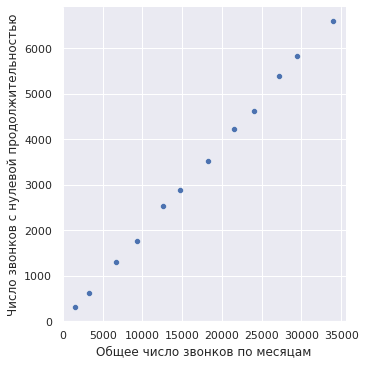

In [10]:
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_calls)
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой продолжительностью');


Округлим все значения в большую сторону (т.к. тариф считается по минутам), а нулевые значения заменим на 1.

In [11]:
calls['duration'] = np.ceil(calls['duration'])

calls.loc[calls['duration'] == 0, 'duration'] = 1

In [12]:
calls['duration']

0          1.0
1          1.0
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float64

### Добавим столбец со значением месяца

In [13]:
internet['month'] = internet['session_date'].dt.month

Построим график зависимости количества нулевых значений от общего числа Интернет-сессий за каждый месяц

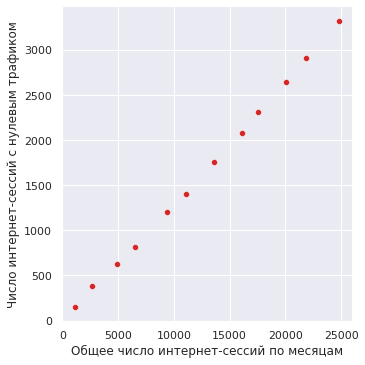

In [14]:
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1

null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')

null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_mb, color='tab:red')
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком');

Округлим все значения в большую сторону (т.к. тариф считается по мегабайтам), а нулевые значения заменим на 1.

### Добавим столбец со значением месяца

In [15]:
messages['month'] = messages["message_date"].dt.month

# Изменение типа данных

In [16]:
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



#### Таблица calls

In [17]:
for dtype in ['float','int','object']:
    selected_dtype = calls.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))


Average memory usage for float columns: 1.03 MB
Average memory usage for int columns: 1.03 MB
Average memory usage for object columns: 6.26 MB


In [18]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

df_int = calls.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

3.09 MB
0.58 MB


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


In [19]:
df_float = calls.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

3.09 MB
1.55 MB


,before,after
float32,NaN,2.0
float64,2.0,NaN


In [20]:
optimized_df = calls.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(calls))
print(mem_usage(optimized_df))

20.24 MB
16.18 MB


In [21]:
df_obj = calls.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
id,202607,202607,1058_239,1


In [22]:
converted_obj = pd.DataFrame()
optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'16.18 MB'

In [23]:
calls = optimized_df

In [24]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           202607 non-null  object        
 1   call_date    202607 non-null  datetime64[ns]
 2   duration     202607 non-null  float32       
 3   user_id      202607 non-null  uint16        
 4   month        202607 non-null  uint8         
 5   nulls_count  39613 non-null   float32       
dtypes: datetime64[ns](1), float32(2), object(1), uint16(1), uint8(1)
memory usage: 5.2+ MB


#### Таблица internet

In [25]:
for dtype in ['float','int','object']:
    selected_dtype = internet.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))


Average memory usage for float columns: 0.76 MB
Average memory usage for int columns: 0.76 MB
Average memory usage for object columns: 4.61 MB


In [26]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

df_int = internet.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

2.28 MB
0.43 MB


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


In [27]:
df_float = internet.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

2.28 MB
1.14 MB


,before,after
float32,NaN,2.0
float64,2.0,NaN


In [28]:
optimized_df = internet.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(internet))
print(mem_usage(optimized_df))

14.91 MB
11.92 MB


In [29]:
df_obj = internet.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
id,149396,149396,1496_554,1


In [30]:
converted_obj = pd.DataFrame()
optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'11.92 MB'

In [31]:
internet = optimized_df

In [32]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float32       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  uint16        
 4   month         149396 non-null  uint8         
 5   nulls_count   19598 non-null   float32       
dtypes: datetime64[ns](1), float32(2), object(1), uint16(1), uint8(1)
memory usage: 3.8+ MB


#### Таблица messages

In [33]:
for dtype in ['float','int','object']:
    selected_dtype = messages.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.63 MB
Average memory usage for object columns: 3.80 MB


In [34]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

df_int = messages.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

1.88 MB
0.35 MB


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


In [35]:
optimized_df = messages.copy()

optimized_df[converted_int.columns] = converted_int


print(mem_usage(messages))
print(mem_usage(optimized_df))

10.41 MB
8.88 MB


In [36]:
df_obj = messages.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
id,123036,123036,1241_102,1


In [37]:
converted_obj = pd.DataFrame()

optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'8.88 MB'

In [38]:
messages = optimized_df

In [39]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  uint16        
 3   month         123036 non-null  uint8         
dtypes: datetime64[ns](1), object(1), uint16(1), uint8(1)
memory usage: 2.2+ MB


#### Таблица tariffs

In [40]:
for dtype in ['float','int','object']:
    selected_dtype = tariffs.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 8
    print("Average memory usage for {} columns: {:03.2f} B".format(dtype,mean_usage_mb))


Average memory usage for float columns: 16.00 B
Average memory usage for int columns: 3.75 B
Average memory usage for object columns: 15.75 B


In [41]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 8 # преобразуем байты в мегабайты
    return "{:03.2f} B".format(usage_mb)

df_int = tariffs.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

30.00 B
18.75 B


,before,after
uint8,NaN,3.0
uint16,NaN,4.0
int64,7.0,NaN


In [42]:
optimized_df = tariffs.copy()

optimized_df[converted_int.columns] = converted_int

print(mem_usage(tariffs))
print(mem_usage(optimized_df))

45.50 B
34.25 B


In [43]:
df_obj = tariffs.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
tariff_name,2,2,ultra,1


In [44]:
converted_obj = pd.DataFrame()

optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'34.25 B'

In [45]:
tariffs = optimized_df

In [46]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      uint16
 1   mb_per_month_included  2 non-null      uint16
 2   minutes_included       2 non-null      uint16
 3   rub_monthly_fee        2 non-null      uint16
 4   rub_per_gb             2 non-null      uint8 
 5   rub_per_message        2 non-null      uint8 
 6   rub_per_minute         2 non-null      uint8 
 7   tariff_name            2 non-null      object
dtypes: object(1), uint16(4), uint8(3)
memory usage: 166.0+ bytes


#### Таблица users

Так как данные разных типов хранятся раздельно, мы исследуем использование памяти разными типами данных. Начнём со среднего показателя использования памяти по разным типам данных.

In [47]:
for dtype in ['float','int','object']:
    selected_dtype = users.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 8
    print("Average memory usage for {} columns: {:03.2f} B".format(dtype,mean_usage_mb))

Average memory usage for float columns: 16.00 B
Average memory usage for int columns: 338.67 B
Average memory usage for object columns: 4997.90 B


Эти сведения дают нам понять то, что большая часть памяти уходит на столбцы, хранящих объектные значения.

Мы часто выясняем сколько памяти используется,поэтому создадим функцию, которая поможет нам сэкономить немного времени.


In [48]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 8 # преобразуем байты в мегабайты
    return "{:03.2f} B".format(usage_mb)

df_int = users.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

1016.00 B
203.50 B


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


В результате можно видеть падение использования памяти с 1016 до 204 байт, то есть — мы снизили потребление памяти. Общее воздействие этой оптимизации на исходный объект DataFrame, однако, не является особенно сильным, так как в нём очень мало целочисленных столбцов.

In [49]:
df_float = users.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

16.00 B
16.00 B


,before,after


Создадим копию исходного объекта DataFrame, используем эти оптимизированные числовые столбцы вместо тех, что присутствовали в нём изначально, и посмотрим на общий показатель использования памяти после оптимизации.

In [50]:
optimized_df = users.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(users))
print(mem_usage(optimized_df))

26989.50 B
26177.00 B


Хотя мы значительно уменьшили потребление памяти столбцами, хранящими числовые данные, в целом, по всему объекту DataFrame, потребление памяти снизилось лишь на 7%. Источником куда более серьёзного улучшения ситуации может стать оптимизация хранения объектных типов.

Для того чтобы понять, где именно мы сможем воспользоваться категориальными данными для снижения потребления памяти, выясним количество уникальных значений в столбцах, хранящих значения объектных типов:

In [51]:
df_obj = users.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
city,500,76,Москва,99
first_name,500,246,Радим,6
last_name,500,419,Андреенко,5
tariff,500,2,smart,351


Заметим, что в столбцах city и  tariff 500 значений из них меньше 50% уникальные, поэтому переведем их в категорию

Создадим цикл, который перебирает все столбцы, хранящие данные типа object, выясняет, не превышает ли число уникальных значений в столбцах 50%, и если это так, преобразует их в тип category.

In [52]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

Теперь сравним то, что получилось после оптимизации, с тем, что было раньше:

In [53]:
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([df_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

24989.50 B
13121.38 B


,before,after
object,4.0,1
category,NaN,1
category,NaN,1
category,NaN,1


In [54]:
optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'14308.88 B'

In [55]:
users = optimized_df

In [56]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    uint16        
 1   age         500 non-null    uint8         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    category      
 4   first_name  500 non-null    category      
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    category      
dtypes: category(3), datetime64[ns](2), object(1), uint16(1), uint8(1)
memory usage: 28.1+ KB


### Вывод
None пропусков в таблицах нет, типы данных скорректированы(столбцы дат и целочисленных значений). В таблице users столбец churn_date заполнили среднем значнием по продолжительности жизни  для того, чтобы можно было проставить корректный тип данных. Округление в признаках длительность и объём для звонков и интернет трафика произведено в большую сторону, согласно условиям данного оператора округление происходит при считывании использования пакета в большую сторну при минимальной единице учета секунда - время, Мб - интернет.

# Статистика

Найдем для каждого пользователя:
* количество сделанных звонков и израсходованных минут 
* разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам.

### Сводная таблица по звонкам

In [57]:
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_grouped.columns = ['calls', 'duration']

In [58]:
calls_grouped 

calls  duration
user_id month                 
1000    5         22     164.0
        6         43     187.0
        7         47     346.0
        8         52     418.0
        9         58     478.0
...              ...       ...
1498    10        41     258.0
1499    9          9      71.0
        10        68     473.0
        11        74     624.0
        12        69     505.0

[3174 rows x 2 columns]

### Сводная таблица по сообщениям

In [59]:
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_grouped.columns = ['messages']

In [60]:
messages_grouped

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

### Сводная таблица по интернет-трафику

In [61]:
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_grouped.columns = ['mb_used']

In [62]:
internet_grouped['gb_used'] = np.ceil(internet_grouped['mb_used']/1024).astype('int')
internet_grouped.loc[internet_grouped['gb_used'] == 0, 'gb_used'] = 1

In [63]:
internet_grouped

mb_used  gb_used
user_id month                       
1000    5       2253.489990        3
        6      23233.769531       23
        7      14003.639648       14
        8      14055.929688       14
        9      14568.910156       15
...                     ...      ...
1498    10     20579.359375       21
1499    9       1845.750000        2
        10     17788.509766       18
        11     17963.310547       18
        12     13055.580078       13

[3203 rows x 2 columns]

In [64]:
internet_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mb_used  3203 non-null   float32
 1   gb_used  3203 non-null   int64  
dtypes: float32(1), int64(1)
memory usage: 51.0 KB


### Объединяем все три сводные таблицы в одну

In [65]:
df = calls_grouped.join([messages_grouped, internet_grouped], how='outer')

In [66]:
df.head(10)

calls  duration  messages       mb_used  gb_used
user_id month                                                  
1000    5       22.0     164.0      22.0   2253.489990      3.0
        6       43.0     187.0      60.0  23233.769531     23.0
        7       47.0     346.0      75.0  14003.639648     14.0
        8       52.0     418.0      81.0  14055.929688     14.0
        9       58.0     478.0      57.0  14568.910156     15.0
        10      57.0     363.0      73.0  14702.490234     15.0
        11      43.0     344.0      58.0  14756.469727     15.0
        12      46.0     341.0      70.0   9817.610352     10.0
1001    11      59.0     444.0       NaN  18429.339844     18.0
        12      63.0     430.0       NaN  14036.660156     14.0

In [67]:
df = df.join(users.loc[:,['user_id', 'tariff']].set_index('user_id'), how='outer')

В итоге мы получаем полную сводную таблицу, в которой для каждого пользователя по месяцам указаны количества звонков, продолжительности звонков, интернет сессий и количество смс сообщений, а так же тарифф.

Однако, ранее мы могли заметить, что все таблицы имеют разное количество строк. 

Это объясняется тем, что у некоторых пользователей отсутствовала информация по конкретным месяцам, например они могли не отправлять в месяц ни одного сообщения, или не выходить в интернет. 

А это значит, что в нашей сводной таблице образовались пропуски.

Заполнил их нулями, исходя из той логики, что пользователь не совершал никаких действий в определенный период.

In [68]:
df['duration'].fillna(0, inplace=True)
df['duration'].isnull().sum()

0

In [69]:
df['calls'].fillna(0, inplace=True)
df['calls'].isnull().sum()

0

In [70]:
df['messages'].fillna(0, inplace=True)
df['messages'].isnull().sum()

0

In [71]:
df['mb_used'].fillna(0, inplace=True)
df['mb_used'].isnull().sum()

0

Наша сводная таблица готова к расчету помесячной выручки. Для расчета выручки необходимо для каждого пользователя вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, а остаток умножить на значение из тарифного плана. Так же нужно добавить к сумме абонентскую плату за месяц.

Объявим функцию total_income_per_month_calculation, которая будет возвращать суммарную выручку за каждого пользователя в месяц. Для расчета выручки необходимо прибавить к абонентской плате дополнительную плату за минуты, сообщения и трафик вышедший за пределы лимитов.

In [72]:
df.head(10)

calls  duration  messages       mb_used  gb_used tariff
user_id month                                                         
1000    5       22.0     164.0      22.0   2253.489990      3.0  ultra
        6       43.0     187.0      60.0  23233.769531     23.0  ultra
        7       47.0     346.0      75.0  14003.639648     14.0  ultra
        8       52.0     418.0      81.0  14055.929688     14.0  ultra
        9       58.0     478.0      57.0  14568.910156     15.0  ultra
        10      57.0     363.0      73.0  14702.490234     15.0  ultra
        11      43.0     344.0      58.0  14756.469727     15.0  ultra
        12      46.0     341.0      70.0   9817.610352     10.0  ultra
1001    11      59.0     444.0       0.0  18429.339844     18.0  smart
        12      63.0     430.0       0.0  14036.660156     14.0  smart

In [73]:
def total_income_per_month_calculation(row):
    #присвоим переменным конкретные значения строк из таблицы
    calls = row['calls']
    duration = row['duration']
    gb_used = row['mb_used']
    messages = row['messages']
    tariff = row['tariff']
    
    #Зададим переменные стоимости и лимитов для каждого из тарифов.
    megabytes_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['mb_per_month_included'])
    messages_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['messages_included'])
    minutes_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['minutes_included'])
    monthly_fee = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_monthly_fee'])
    price_for_gb = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_gb'])
    price_for_message = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_message'])
    price_for_minute = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_minute'])
    
    over_gb = 0                #объявляем переменные перерасхода для трафика, сообщений и звонков.
    over_msg = 0               #в них мы будем сохранять для каждого пользователя значения сверх лимита
    over_calls = 0             #затем при наличии перерасхода минут/сообщений/трафика значения умножим на стоимость.
    
    #если пользователь вышел за лимит трафика, посчитаем сколько рублей он должен заплатить за дополнительный трафик
    #для получения цены в рублях умножим значения на стоимость.
    
    gb_used = row['gb_used']

    if gb_used > (megabytes_included/1024):
        over_gb = (gb_used - megabytes_included/1024) * price_for_gb
    
    #аналогично поступаем с минутами и сообщения
    if duration > minutes_included:
        over_calls = (duration - minutes_included) * price_for_minute
        
    if messages > messages_included:
        over_msg = (messages - messages_included) * price_for_message 
    
    #считаем суммарную выручку с пользователя, добавив ко всем перерасходам абонентскую плату.
    return over_gb + over_msg + over_calls + monthly_fee

In [74]:
df['total_income'] = df.apply(total_income_per_month_calculation, axis = 1)

In [75]:
df.drop(columns = ['mb_used'],axis = 1).head(10)

calls  duration  messages  gb_used tariff  total_income
user_id month                                                         
1000    5       22.0     164.0      22.0      3.0  ultra        1950.0
        6       43.0     187.0      60.0     23.0  ultra        1950.0
        7       47.0     346.0      75.0     14.0  ultra        1950.0
        8       52.0     418.0      81.0     14.0  ultra        1950.0
        9       58.0     478.0      57.0     15.0  ultra        1950.0
        10      57.0     363.0      73.0     15.0  ultra        1950.0
        11      43.0     344.0      58.0     15.0  ultra        1950.0
        12      46.0     341.0      70.0     10.0  ultra        1950.0
1001    11      59.0     444.0       0.0     18.0  smart        1150.0
        12      63.0     430.0       0.0     14.0  smart         550.0

In [76]:
df['total_income'].max()

6824.0

## Вывод

На этапе предобработки данных мы постарились убрать недочеты, выявленные на этапе изучения общей информации:

  Был изменен тип данных с object на datetime64 для всех столбцов, содержащих дату.
    
   Было произведено округление в большую сторону значений минут разговора и потраченного трафика.
    
   Пропущенные значения в столбце 'churn_date' в таблице users не были заполнены, в связи с тем, что в дальнейшем анализе эти данные не используются, а так же исходя из той логики, что незаполненные значения означают, что пользователь пользуется тарифом до сих пор.
    
   Было принято решение не изменять и не удалять нулевые значения в столбцах с продолжительностью разговора и использованного трафика, исходя из той логики, что нули означают либо непринятые вызовы, либо ошибочно записанную интернет сессию.
    
   Был удален лишний столбец из датафрейма internet.
   
   Были добавлены столбцы со значением месяца в датафреймы calls, internet, messages.
    
   Была создана сводная общая таблица, в которой были посчитана сумма продолжительности разговоров, отправленных сообщений и израсходованного трафика для каждого пользователя по месяцам.
    
   Была расчитана ежемесечная выручка с каждого пользователя.
    
   Такая предобработка данных позволит нам провести быстрый и информативный анализ данных, вычислить основные статистические характеристики, а так же проверить гипотезы.

# Анализ данных

Выясним, сколько минут разговора, трафика и сообщений в среднем в месяц требуется пользователям каждого тарифа. Создадим сводную таблицу, сгруппировав данные по пользователям и используя функцию для нахождения медианы.

In [77]:
medians_per_month = df.pivot_table(index='user_id', 
                        values=['duration', 'gb_used', 'messages'], 
                        aggfunc='median')

In [78]:
medians_per_month.join(users.loc[:,['user_id', 'tariff']].set_index('user_id'), how='outer').head()

,duration,gb_used,messages,tariff
user_id,,,,
1000,345.0,14.5,65.0,ultra
1001,437.0,16.0,0.0,smart
1002,221.0,18.0,11.0,smart
1003,844.0,12.0,83.0,ultra
1004,136.5,18.0,154.5,ultra


Как видно, пользователи по разному пользуются услугами: кто-то за месяц не отправляет ни одного сообщения, а кто-то проговаривает 700 минут.

Посчитаем среднее, медиану, дисперсию и стандартное отклонение для продолжительности звонков, использованного траффика и количества сообщений.

In [79]:
statistics = df.pivot_table(index=['tariff'], values=['duration', 'gb_used', 'messages'], 
                    aggfunc={'duration': [np.mean, np.median, np.var, np.std], 
                             'gb_used': [np.mean, np.median, np.var, np.std], 
                             'messages': [np.mean, np.median, np.var, np.std]})
statistics.applymap("{:.1f}".format) #округлим выводимые значения используя format

duration                         gb_used                   messages  \
           mean median    std       var    mean median  std   var     mean   
tariff                                                                       
smart     429.5  435.0  194.9   37974.8    16.3   17.0  5.7  32.9     33.4   
ultra     540.8  532.0  325.7  106105.7    19.7   19.0  9.7  94.1     49.4   

                             
       median   std     var  
tariff                       
smart    28.0  28.2   796.8  
ultra    38.0  47.8  2285.3

## Вывод

Из показателей можно сделать следующие выводы:

В среднем пользователь смарт проговаривает **430 минуты** в месяц, а пользователь ультра - **532 минут**.

В среднем пользователь смарт использует **16.3 гб.** трафика, а пользователь тарифа ультра - **19 гб**.

В среднем пользователь смарт отправляет **28 сообщений**, а пользователь тарифа ультра - **38**.
Дисперсии тарифа ультра больше, чем у тарифа смарт, это говорит нам о большем размахе значений.

В целом пользователи **тарифа "Ультра" пользуются услугами оператора более свободно**, они больше разговаривают, больше проводят времени в интернете, отправляют больше сообщений, при этом среднестатистический пользователь не превышает тарифные лимиты. С другой стороны среднестатистическому **пользователю тарифа "Смарт" приходится докупать 1 гб. трафика сверх лимита**.

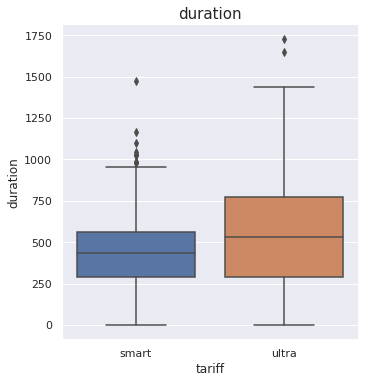

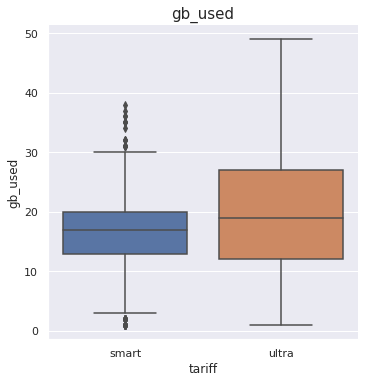

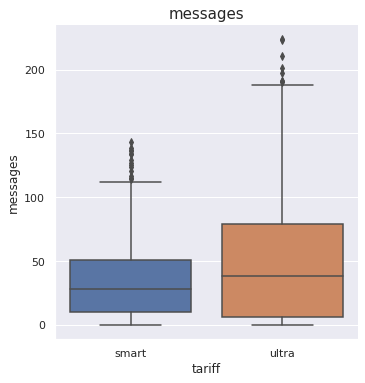

In [80]:
for column in ['duration', 'gb_used', 'messages']:
    sns.catplot(x='tariff', y=column, data=df, kind='box')
    plt.title(column, fontsize=15)

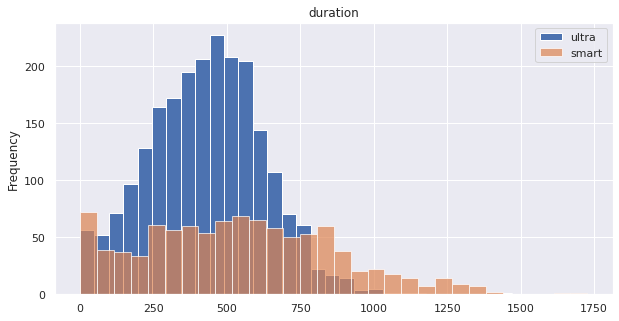

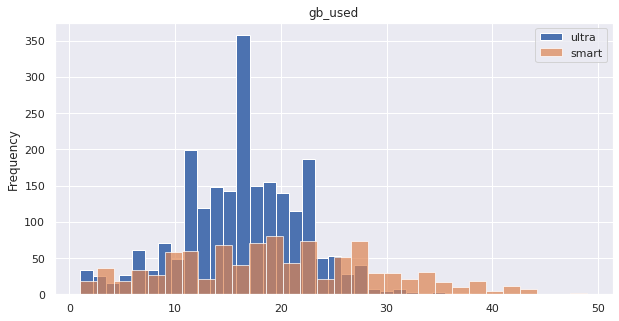

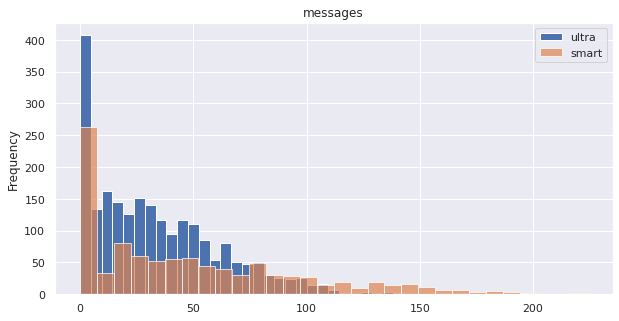

In [81]:
list_of_columns=['duration', 'gb_used', 'messages']
tariffs = ['ultra','smart']
for column in list_of_columns:
        df.loc[df.loc[:,'tariff'] == 'smart'][column].plot( kind = 'hist', bins = 30,label = 'smart', figsize = (10,5))
        df.loc[df.loc[:,'tariff'] == "ultra"][column].plot( kind = 'hist',bins = 30,alpha =0.7,label = 'ultra',figsize = (10,5))
        
        plt.title(column)
        plt.legend(['ultra', 'smart'])
        plt.show()

Из боксплотов и диаграмм мы можем наглядно заметить, что **дисперсии и размахи больше для тарифа Ultra**, так же **средние и медианы смещены для тарифа Ultra в большую сторону в большей степени**, чем для тарифа Smart. Так же стоит отметить, что **среди значений тарифа Ultra присутствует меньше выбросов**.

Распределения продолжительности звонков и использованного трафика для обоих тарифов близки к нормальному распределению и относительно симметричны, однако имеют "тяжелые" хвосты. Будем считать, что распределение этих величин - **распределение Стьюдента**.

Гистограмма распределения количества отправленных сообщений имеет ярко выраженный **скос вправо**. Так же из данной гистограммы наглядно видно, что **среднее значение больше, чем медиана**.

Выясним, как в течении года изменялся доход от пользователей тарифа смарт. Создадим сводную таблицу, содержащую только пользователей тарифа смарт и сгруппируем ее по месяцам, вычислим медиану каждого месяца.

In [82]:
monthly_overpayment_smart = df.query('tariff=="smart"').pivot_table(index='month', 
                        values=['total_income'],
                        aggfunc='median')
months = ['Январь', 'Февраль', 'Март', 'Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь', 'Ноябрь','Декабрь']
monthly_overpayment_smart['months'] = months

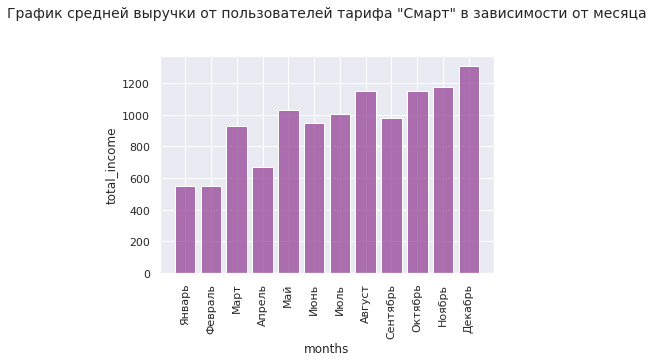

In [83]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# create dataset
total_income = monthly_overpayment_smart['total_income']
months = monthly_overpayment_smart['months']

width = [0.1,0.2,3,1.5,0.3]
x_pos = np.arange(len(months))
 
# Create bars and choose color
plt.bar(x_pos, total_income, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names

plt.xlabel('months')
plt.ylabel('total_income')
 
# Create names on the x axis
plt.xticks(x_pos, months, rotation=90)

# Create names on the hist
plt.title('График средней выручки от пользователей тарифа "Смарт" в зависимости от месяца\n\n', fontsize=(14))

# Show graph
plt.show()

In [84]:
df.pivot_table(index='tariff', values='total_income', aggfunc='sum')

,total_income
tariff,
smart,2913190.0
ultra,2039100.0


In [85]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

**Тариф "Смарт"** принес компании в 2018 году прибыль в **2,9 млн. руб**, в то время как тариф **"Ультра" - 2,04**.

Пользователей тарифа **"Смарт" - 351 человек, а "Ультра" имеет всего 149 пользователей**.

Выясним равны ли средние выручки по тарифам.

## Вывод

В результате анализа данных, нам удалось расчитать основные статистические характерстики для значений отправленных сообщений, продолжительности звонков и использованного трафика. По этим характеристикам можно сделать следующий вывод:

1) В среднем пользователь смарт проговаривает **430 минуты** в месяц, а пользователь ультра - **532 минут**.

2) В среднем пользователь смарт использует **16.3 гб. трафика**, а пользователь тарифа ультра - **19 гб**.

3) В среднем пользователь смарт отправляет **28 сообщений**, а пользователь тарифа ультра - **38**.

Дисперсии тарифа ультра больше, чем у тарифа смарт, это говорит нам о большем размахе значений.

Так же мы построили боксплоты и гистограммы распределений значений. Графики позволили нам убедиться в том, что размах значений для всех действий пользователей тарифа "Ультра" шире, чем размах значений пользователей тарифа "Смарт". Боксплоты наглядно проиллюстрировали наличие большого количества выбросов пользователей тарифа "Смарт". Возможно для этих пользователей тариф Ультра мог бы подойти лучше.

К концу года, в среднем, пользователем тарифа "Смарт" стало сильно не хватать заложенных в тариф лимитов, за услуги связи в декабре они в среднем заплатили 1200 руб. за услуги связи, или если говорить проще, две с половиной абонентских платы.

Суммарная выручка от всех пользователей тарифа "Смарт" составила 2,6 млн. руб, в то время как пользователи тарифа "Ультра" принесли 2,04 млн. руб. дохода. Стоит так же проанализировать средние выручки от пользователей этих тарифов.

# Проверка гипотез

Проверим гипотезу о том, что средняя выручка от пользователей тарифа "Смарт" равна средней выручке от пользователей с тарифа "Ультра". Нулевая гипотеза будет гласить о том, что средние выручки от тарифов равны, а альтернативная - о том, что средние выручки отличаются.

𝐻0  - средняя выручка от пользователей тарифа "Ультра" равна средней выручке от пользователей тарифа "Смарт"

𝐻1 - средние выручки отличаются

𝛼=0.1% - уровень значимости

In [86]:
alpha=.001

In [87]:
smart = df.query('tariff=="smart"')['total_income']
ultra = df.query('tariff=="ultra"')['total_income']

In [88]:
smart

user_id  month
1001     11       1150.0
         12        550.0
1002     6         550.0
         7        1150.0
         8        1550.0
                   ...  
1498     10       1750.0
1499     9         550.0
         10       1150.0
         11       1549.0
         12        613.0
Name: total_income, Length: 2229, dtype: float64

In [89]:
ultra

user_id  month
1000     5        1950.0
         6        1950.0
         7        1950.0
         8        1950.0
         9        1950.0
                   ...  
1495     8        1950.0
         9        2400.0
         10       1950.0
         11       3300.0
         12       1950.0
Name: total_income, Length: 985, dtype: float64

Выясним, как различаются дисперсии выборок пользователей тарифа смарт и тарифа ультра. Зададим степень свободы 1, т.к. работаем с выборками из генеральной совокупности

In [90]:
print('Дисперсия выборки пользователей тарифа Смарт:', smart.var(ddof=1))
print('Дисперсия выборки пользователей тарифа Ультра:', ultra.var(ddof=1))

Дисперсия выборки пользователей тарифа Смарт: 684832.7240895072
Дисперсия выборки пользователей тарифа Ультра: 141516.7450786183


Проверим гипотезу, используя встроенную в библиотеку scipy функцию ttest_ind - которая вычисляет уровень значимости критерия Стьюдента для двух независимых выборок. Т.к. дисперсии для выборок сильно отличаются, то небоходимо учесть это в функции, добавив аргумент equal_var=False.

In [91]:
results = st.ttest_ind(smart, ultra, equal_var=False) 
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.7897104728368674e-238
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу, гласящую о том, что средние выручки пользователей тарифов равны.

In [92]:
df.pivot_table(index='tariff', values='total_income', aggfunc='mean')

,total_income
tariff,
smart,1306.949305
ultra,2070.152284


Действительно, из таблицы видно, что средняя выручка отличается почти в два раза

Исходя из результатов проверки гипотезы, мы так же можем с вероятностью 99,9% утверждать, что средняя выручка пользователя тарифа "Смарт" и тарифа "Ультра" отличаются.

Проверим гипотезу о том, что средняя выручка от пользователей из Москвы равна средней выручке от пользователей из других регионов.

𝐻0  - средняя выручка от пользователей из г. Москва равно средней выручке пользователей других городов.

𝐻1  - средние выручки отличаются

𝛼=0.1%  - уровень значимости

In [93]:
df = df.join(users.loc[:,['user_id', 'city']].set_index('user_id'), how='outer')

In [94]:
moscow = df.query('city == "Москва"')['total_income']
others = df.query('city != "Москва"')['total_income']

In [95]:
print('Дисперсия выборки пользователей г. Москвы:', moscow.var(ddof=1))
print('Дисперсия выборки пользователей остальных городов:', others.var(ddof=1))

Дисперсия выборки пользователей г. Москвы: 567709.3186176921
Дисперсия выборки пользователей остальных городов: 659676.7721174321


In [96]:
results = st.ttest_ind(moscow, others, equal_var=False) 
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5749090668370982
Не получилось отвергнуть нулевую гипотезу


В данном случае нам не удалось отвергнуть нулевую гипотезу. 

## Вывод по статистическому анализу

В результате статистического анализа мы проверили две гипотезы с уровнем значимости  𝛼=5% :

1. Первая нулевая гипотеза гласила о том, что средние выручки от пользователей тарифа "Smart" и тарифа "Ultra" равны.
2. Вторая нулевая гипотеза гласила о том, что средние выручки от пользователей из Москвы равны средним выручкам от пользователей из других городов.

В качестве альтернативных гипотез для обоих случаев мы выбрали утверждение о том, что средние выручки не будут равны. Для оценки мы использовали уровень значимости критерия Стьюдента для независимых выборок. В данном случае мы используем именно его, т.к. средние выручки выборок не зависят друг от друга.

* В случае с тарифами мы отвергли нулевую гипотезу, и сделали вывод о том, что мы можем с вероятностью 99,9% утверждать, что средняя выручка пользователя тарифа "Смарт" и тарифа "Ультра" отличаются
* В случае с городами мы не смогли отвергнуть нулевую гипотезу.

# Общий вывод

Для анализа нам была предоставлена информация о пользователях телекомуникационной компании «Мегалайн» за 2018 год. Вся необходима информация была сохранена в 5 датасетах, содержащих общую информацию о клиентах, информацию о датах и продолжительности звонков, отправленных сообщениях, интернет сессиях и использованном трафике, а так же общую информацию о тарифах компании.

Более перспективным для компании является тариф "Ультра", на момент исследования, он имеет намного меньше пользователей, однако средняя выручка, которую приносит тариф компании - больше. Среди пользователей тарифа "Смарт" заметна тенденция к увеличению потребления услуг компании, что в конечном итоге может привести их к более дорогому "Ультра". Увеличение количества пользователей этого тарифа смогло бы значительно увеличить выручку компании. Тариф "Смарт", напротив, прекрасно показывает себя, при текущих параметрах. Ему удалось привлечь значительное количество пользователей, которые вынуждены доплачивать за дополнительные услуги по более высоким тарифам, чем пользователи "Ультра", и тем самым приносить значительный доход.